# Ausgangslage

Die Aufgabe im Modul Data Science & Machine Learning war es einen Datensatz anhand eines Machine-Learning-Verfahrens so zu trainieren, dass der Algorithmus eine wage Vorhersage erstellen kann, wie sich die Daten in Zukunft verhalten könnten. 

Das Team entschied sich für einen eigenen Datensatz. Ein Raperry-Pi sammelte während dem Zeitraum von Juni 2020 bis April 2021 alle 5 Minuten die freien Parkplätze von ausgewählten Parkhäusern in Zürich und Luzern zusammen. So entstanden über 15 Mio. Datensätze, welche sich perfekt dazu eigneten, eine Vorhersage betreffend den freien Parkplätzen in den einzelnen Parkhäusern zu einer beliebigen Tageszeit zu wagen. Für die Arbeit wurden nur die Daten der Zürcher Parkhäuser verwendet.


# Problem
Eine genaue Anleitung wie man eigene Daten auswertet ist etwas, dass es im Internet nicht zu finden gibt. Das Projektteam wird so einiges recherchieren und testen müssen. Bis auf die Einmaligkeit unserer Daten sind wir aber sehr positiv gestimmt, dieses Projekt erfolgreich abschliessen zu können.

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

# Laden der Daten
Die Daten liegen im Order `data/` im root Verzeichnis des Projektes. Da beim Scraping der Daten jeden Tag ein neues File erstellt wurde, müssen die Daten in einer Schleife für pandas geladen werden. Zusätzlich ist in jeder Datei der Header (sprich die Zeile mit den Spaltennamen) mehrfach enthalten. Bei dem Skript wird nämlich alle fünf Minuten einfach ein ganzes CSV dem bestehenden File angehängt. 

In [2]:
path = r'data' # ordner mit daten
all_files = glob.glob(path + "/zurich*.csv")

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, sep=";") # laden der daten inklusive erster Zeile
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True) 
print(df.size)

15653495


# Säubern der Daten
Nachfolgend werden die Daten gesäubert. Bedeutet der Header, welcher für jeden neuen Datensatz hinzugefügt wurde, wird aus dem CSV gelöscht. Ausserdem werden alle Datensätze die keine Belegungsangaben haben mit einer 0 aufgefüllt. Dies weil ansonsten die Zellen nicht zu einem Int umgewandelt werden können.

In [3]:
df = df[df.ne(df.columns).any(1)] # entfernt alle Zeilen die gleich der ersten Zeile sind (Doppelte Header).
df = df[df['free_parking'] != 'free_parking']

In [4]:
df['free_parking_0'] = df['free_parking'].fillna(0)
df['free_parking_0'] = df['free_parking_0'].astype('int')

df['date'] = pd.to_datetime(df['date'], errors='coerce')

Der Datensatz hat folgende Dimensionen (3050498, 6). Die Spalte Date wurde zu einem Datum umgewandelt, die Spalte free_parking_0 wurde hinzugefüht und ist der int Wert von free_parking.

In [5]:
print(df.shape)
print(df.dtypes)

(3050498, 6)
parking_id                object
free_parking              object
date              datetime64[ns]
status                    object
publi_date                object
free_parking_0             int64
dtype: object


Dann können die Daten ein erstes Mal ausgegeben und überprüft werden, ob über den Zeitraum überhaupt Daten gesammelt wurden. Aufgrund von Stromausfällen und einem Umzugstermin, ist gut ersichtlich, dass die Daten nicht ganz konsistent sind. Die Datenausschläge nach oben, also dass das Raspberry Pi mehr Daten gesammelt hat, kann sich das Projektteam nicht erklären.

<AxesSubplot:xlabel='date'>

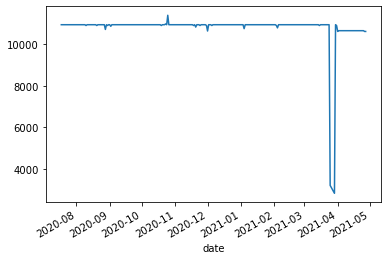

In [6]:
df['parking_id'].groupby(df.date.dt.normalize()).count().plot()

In der Grafik unten sind die ausreisser noch besser ersichtlich. Die Fehlenden Daten ende November sind aufgrund eines Internetausfalls zu erklären. Die Ausreisser nach oben ende Oktober kann sich das Team nicht erklären. 

<ipython-input-7-6869764b1259>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_detail['day_of_month'] = df_detail['date'].dt.day


<AxesSubplot:xlabel='date'>

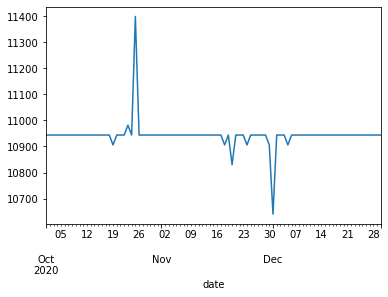

In [7]:
mask = (df['date'] > '2020-10-01') & (df['date'] <= '2020-12-31')
df_detail = df.loc[mask]
df_detail['day_of_month'] = df_detail['date'].dt.day
df_detail['parking_id'].groupby(df_detail.date.dt.normalize()).count().plot()

# Transform
In diesem Abschitt werden die Daten für das Verfahren vorbereitet. Damit die Feautures später richtig funktionieren, müssen aus dem Datumsformat Ganzzahlen gebildet werden. So werden den Wochentagen Nummern von 0 bis 6 zugewiesen oder den Stunden des jeweiligen Tages die Nummern 0 bis 23. Ein weiteres Feature, dass gebildet wird ist die Kategorisierung eines Tages in Morgen, Mittag, Nachmittag und Abend (Nummern 0 bis 3).

In [8]:
df['month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day
df['dayname_of_week'] = df['date'].dt.day_name()
df['hour'] = df['date'].dt.hour
df['is_weekend'] = df['dayname_of_week'].apply(lambda x : 1 if x in ['Saturday','Sunday'] else 0)
df

,parking_id,free_parking,date,status,publi_date,free_parking_0,month,day_of_month,dayname_of_week,hour,is_weekend
0,accu,172,2021-04-17 00:00:02.659943,open,"Fri, 16 Apr 2021 20:34:27 GMT",172,4,17,Saturday,0,1
1,albisriederplatz,60,2021-04-17 00:00:02.660041,open,"Fri, 16 Apr 2021 21:17:27 GMT",60,4,17,Saturday,0,1
2,bleicherweg,139,2021-04-17 00:00:02.660124,open,"Fri, 16 Apr 2021 21:19:27 GMT",139,4,17,Saturday,0,1
3,center_11,340,2021-04-17 00:00:02.660203,open,"Fri, 16 Apr 2021 20:58:27 GMT",340,4,17,Saturday,0,1
4,cp,555,2021-04-17 00:00:02.660281,open,"Fri, 16 Apr 2021 21:58:27 GMT",555,4,17,Saturday,0,1
...,...,...,...,...,...,...,...,...,...,...,...
3130694,zuerichhorn,47,2021-03-07 23:55:02.323986,open,"Sun, 07 Mar 2021 20:44:27 GMT",47,3,7,Sunday,23,1
3130695,eisfeld,192,2021-03-07 23:55:02.324074,open,"Sun, 07 Mar 2021 21:56:27 GMT",192,3,7,Sunday,23,1
3130696,theater_11,131,2021-03-07 23:55:02.324166,open,"Sun, 07 Mar 2021 21:45:27 GMT",131,3,7,Sunday,23,1
3130697,unispital_sued,76,2021-03-07 23:55:02.324259,open,"Sun, 07 Mar 2021 21:59:28 GMT",76,3,7,Sunday,23,1


In [9]:
def daypart(date):
    hour = date.hour
    if hour in [22,23,0,1,2,3,4]:
        return "night"
    elif hour in [5,6,7,8,9]:
        return "morning"
    elif hour in [10,11,12,13]:
        return "noon"
    elif hour in [14,15,16,17]:
        return "afternoon"
    elif hour in [18,19,20,21]:
        return "evening"
    else: return "midnight"
    
# methode auf daten anwenden
df['daypart'] = df['date'].apply(daypart)

In [12]:
df["daypart_cat"] = df["daypart"].astype('category')
df["daypart_cat"] = df["daypart_cat"].cat.codes


def day_of_week_cat(day):
    if day == "Monday":
        return 0
    elif day == "Tuesday":
        return 1
    elif day == "Wednesday":
        return 3
    elif day == "Thursday":
        return 4
    elif day == "Friday":
        return 5
    elif day == "Saturday":
        return 6
    else: return 7

df["day_of_week"] = df["dayname_of_week"].apply(day_of_week_cat)

df

,parking_id,free_parking,date,status,publi_date,free_parking_0,month,day_of_month,dayname_of_week,hour,is_weekend,daypart,daypart_cat,day_of_week
0,accu,172,2021-04-17 00:00:02.659943,open,"Fri, 16 Apr 2021 20:34:27 GMT",172,4,17,Saturday,0,1,night,3,6
1,albisriederplatz,60,2021-04-17 00:00:02.660041,open,"Fri, 16 Apr 2021 21:17:27 GMT",60,4,17,Saturday,0,1,night,3,6
2,bleicherweg,139,2021-04-17 00:00:02.660124,open,"Fri, 16 Apr 2021 21:19:27 GMT",139,4,17,Saturday,0,1,night,3,6
3,center_11,340,2021-04-17 00:00:02.660203,open,"Fri, 16 Apr 2021 20:58:27 GMT",340,4,17,Saturday,0,1,night,3,6
4,cp,555,2021-04-17 00:00:02.660281,open,"Fri, 16 Apr 2021 21:58:27 GMT",555,4,17,Saturday,0,1,night,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130694,zuerichhorn,47,2021-03-07 23:55:02.323986,open,"Sun, 07 Mar 2021 20:44:27 GMT",47,3,7,Sunday,23,1,night,3,7
3130695,eisfeld,192,2021-03-07 23:55:02.324074,open,"Sun, 07 Mar 2021 21:56:27 GMT",192,3,7,Sunday,23,1,night,3,7
3130696,theater_11,131,2021-03-07 23:55:02.324166,open,"Sun, 07 Mar 2021 21:45:27 GMT",131,3,7,Sunday,23,1,night,3,7
3130697,unispital_sued,76,2021-03-07 23:55:02.324259,open,"Sun, 07 Mar 2021 21:59:28 GMT",76,3,7,Sunday,23,1,night,3,7


# Save
Die transformierten Daten werden in einem pickel abgespeichert, welches dafür bekannt ist dataframes einfach & schnell speichern zu können.

In [13]:
df.to_pickle("data.pkl")